In [3]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import joblib

In [4]:
# -------------------------
# Step 2: Load Dataset
# -------------------------
file_path = "/content/drive/MyDrive/Customer Churn Prediction /WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

print("Initial Data Shape:", df.shape)
print("Initial Data Sample:\n", df.head())

Initial Data Shape: (7043, 21)
Initial Data Sample:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSup

In [5]:
# -------------------------
# Step 3: Basic Data Cleaning
# -------------------------

# Drop customerID (identifier, no predictive value)
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Check for remaining missing values
print("\nMissing values per column:\n", df.isna().sum())


Missing values per column:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


/tmp/ipython-input-1419734961.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


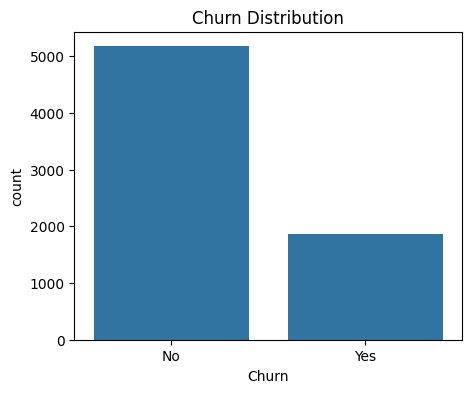

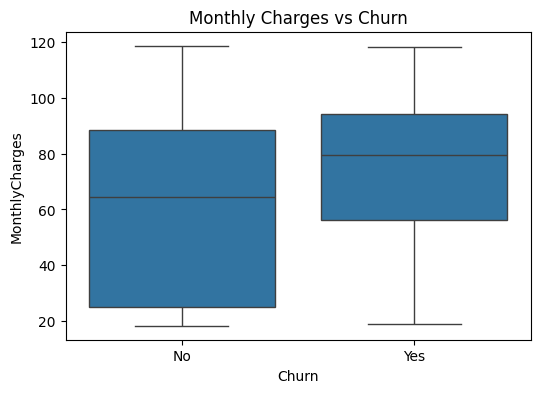

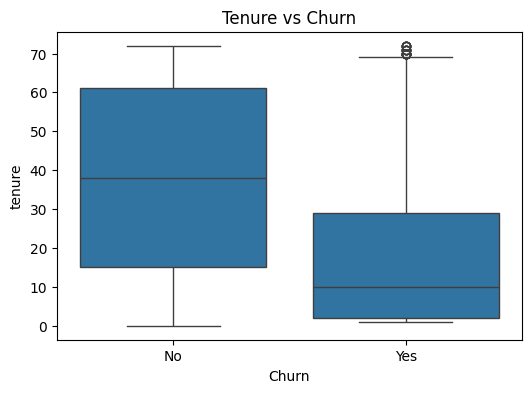

In [6]:
# -------------------------
# Step 4: Exploratory Data Analysis (EDA)
# -------------------------

# Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Churn vs MonthlyCharges
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

# Churn vs tenure
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

In [7]:
# -------------------------
# Step 5: Encode Categorical Variables
# -------------------------

# Encode binary Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# One-hot encode remaining categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# (Churn is now numeric, so it won't be in cat_cols)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("\nData after encoding shape:", df.shape)


Data after encoding shape: (7043, 31)


In [8]:
# -------------------------
# Step 6: Feature Scaling
# -------------------------

scaler = StandardScaler()
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical] = scaler.fit_transform(df[numerical])

In [9]:
# -------------------------
# Step 7: Train-Test Split
# -------------------------

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Churn distribution in Train:\n", y_train.value_counts(normalize=True))



Train shape: (5634, 30) Test shape: (1409, 30)
Churn distribution in Train:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


In [10]:
# -------------------------
# Step 8: Baseline Random Forest (with class imbalance handling)
# -------------------------

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Baseline Random Forest Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


=== Baseline Random Forest Performance ===
Accuracy: 0.7877927608232789
ROC-AUC: 0.8258092433284251

Confusion Matrix:
 [[928 107]
 [192 182]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [11]:
# -------------------------
# Step 9: Cross-Validation
# -------------------------

cv_scores = cross_val_score(
    rf_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)
print("\nCross-Validation ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())


Cross-Validation ROC-AUC Scores: [0.8377058  0.83372716 0.82200128 0.81353707 0.80555297]
Mean CV ROC-AUC: 0.8225048554267633


In [12]:
# -------------------------
# Step 10: Hyperparameter Tuning (GridSearchCV)
# -------------------------

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters from Grid Search:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate tuned model
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Tuned Random Forest Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

=== Tuned Random Forest Performance ===
Accuracy: 0.7665010645848119
ROC-AUC: 0.8419101500942932

Confusion Matrix:
 [[802 233]
 [ 96 278]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [13]:
# -------------------------
# Step 11: Logistic Regression Baseline (Model Comparison)
# -------------------------

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


=== Logistic Regression Performance ===
Accuracy: 0.7388218594748048
ROC-AUC: 0.8417318969748636

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



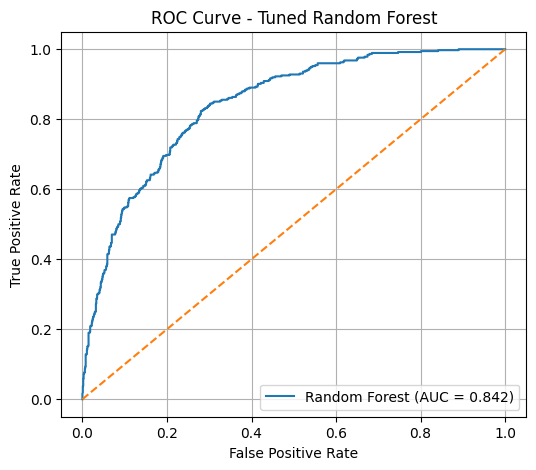

In [14]:
# -------------------------
# Step 12: ROC Curve for Best RF
# -------------------------

fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, y_prob_best)))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest")
plt.legend()
plt.grid(True)
plt.show()

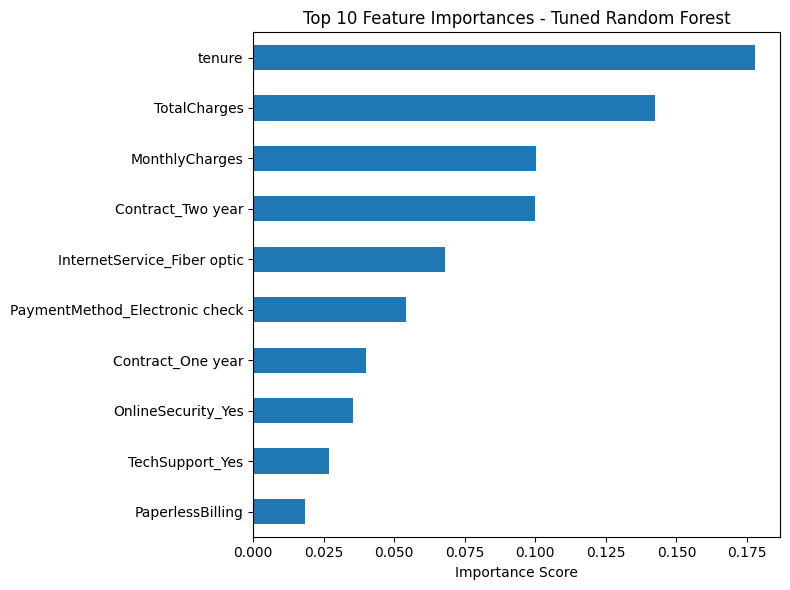


Top 10 Important Features:
 tenure                            0.177828
TotalCharges                      0.142565
MonthlyCharges                    0.100063
Contract_Two year                 0.099758
InternetService_Fiber optic       0.068013
PaymentMethod_Electronic check    0.054067
Contract_One year                 0.039847
OnlineSecurity_Yes                0.035214
TechSupport_Yes                   0.026911
PaperlessBilling                  0.018436
dtype: float64


In [15]:
# -------------------------
# Step 13: Feature Importance Plot (Top 10)
# -------------------------

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind='barh')
plt.title("Top 10 Feature Importances - Tuned Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:\n", top_features)

In [16]:
# -------------------------
# Step 14: Save the Best Model
# -------------------------

joblib.dump(best_rf, "telco_churn_best_random_forest.pkl")
print("\nModel saved as 'telco_churn_best_random_forest.pkl'")


Model saved as 'telco_churn_best_random_forest.pkl'
